In [1]:
# 数据处理
import numpy as np
import pandas as pd

# 读入数据集

df = pd.read_csv('./Telco-Customer-Churn.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [3]:
# 发现TotalCharges有11个' '空值
df['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [4]:
# 数据初步清洗
# 首先进行初步的数据清洗工作，包含错误值和异常值处理，并划分类别型和数值型字段类型，
# 其中清洗部分包含：MultipleLines、OnlineSecurity、OnlineBackup、DeviceProtection、TechSupport、
# StreamingTV、StreamingMovies：
# 错误值处理 TotalCharges：异常值处理 tenure：自定义分箱
# 错误值处理
repl_columns = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport', 'StreamingTV', 'StreamingMovies']
for i in repl_columns:
    df[i] = df[i].replace({ 'No internet service': 'No'})
df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

# 替换值SeniorCitizen
df["SeniorCitizen"] = df["SeniorCitizen"].replace({1: "Yes", 0: "No"}) 

# 替换值TotalCharges
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
# TotalCharges空值：数据量小，直接删除
df = df.dropna(subset=['TotalCharges'])
df.reset_index(drop=True, inplace=True) # 重置索引

In [5]:
# 转换数据类型
df['TotalCharges'] = df['TotalCharges'].astype('float')
# 转换tenure
def transform_tenure(x):
    if x <= 12:
        return('Tenure_1')
    elif x <= 24:
        return('Tenure_2')
    elif x <= 36:
        return('Tenure_3')
    elif x <= 48:
        return('Tenure_4')
    elif x <= 60:
        return('Tenure_5')
    else:
        return('Tenure_over_5')
df['tenure_group'] = df.tenure.apply(transform_tenure)

# 数值型和类别型字段
Id_col = ['customerID']

target_col = ['Churn']

cat_cols = df.nunique()[df.nunique() < 10].index.tolist()

num_cols = [i for i in df.columns if i not in cat_cols + Id_col]

print( '类别型字段：\n', cat_cols)

print( '-' * 30)

print( '数值型字段：\n', num_cols)

类别型字段：
 ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'tenure_group']
------------------------------
数值型字段：
 ['tenure', 'MonthlyCharges', 'TotalCharges']


In [6]:
#探索性分析
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

#目标变量Churn分布
df['Churn'].value_counts()

trace0 = go.Pie(labels=['未流失客户','流失客户'],
#                 labels=df['Churn'].value_counts().index, 
                values=df['Churn'].value_counts().values,
                hole=.5,
                rotation=90,
                marker=dict(colors=['rgb(154,203,228)', 'rgb(191,76,81)'], 
                            line=dict(color='white', width=1.3))
               )
data = [trace0] 
layout = go.Layout(title='目标变量Churn分布', font=dict(size=26))

fig = go.Figure(data=data, layout=layout)
# py.offline.plot(fig, filename= '整体流失情况分布.html', auto_open=False)
py.offline.iplot(fig)

In [7]:
def plot_bar(input_col: str, target_col: str, title_name: str):
    cross_table = round(pd.crosstab(df[input_col], df[target_col], normalize='index')*100, 2)

    # 索引
    index_0 = cross_table.columns.tolist()[0] 
    index_1 = cross_table.columns.tolist()[1] 

    # 绘图轨迹
    trace0 = go.Bar(x=cross_table.index.tolist(), 
                    y=cross_table[index_0].values.tolist(), 
#                     name=index_0,
                    marker=dict(color='rgb(154,203,228)'),
                    name='未流失客户'
                   ) 
    trace1 = go.Bar(x=cross_table.index.tolist(), 
                    y=cross_table[index_1].values.tolist(), 
#                     name=index_1,
                    marker=dict(color='rgb(191,76,81)'),
                    name='流失客户'
                   ) 

    data = [trace0, trace1] 
    # 布局
    layout = go.Layout(title=title_name, bargap=0.4, barmode='stack', font=dict(size=26))
    
    # 画布
    fig = go.Figure(data=data, layout=layout)
    # 绘图
    # py.offline.plot(fig, filename=f'./html/{title_name}.html',auto_open=False) 
    py.offline.iplot(fig)

#性别与是否流失的关系
chars = ['gender', 'SeniorCitizen', 'Dependents', 'tenure_group', 'tenure']
for char in chars:
    plot_bar(input_col=char, target_col='Churn', title_name=char+'与是否流失的关系')

In [8]:
def plot_histogram(input_col: str, title_name: str):
    churn_num = df[df['Churn'] == 'Yes'][input_col]
    not_churn_num = df[df['Churn'] == 'No'][input_col] 
    
    # 图形轨迹
    trace0 = go.Histogram(x=churn_num, 
                          bingroup=25,
                          histnorm='percent',
                          name='流失客户',
                          marker=dict(color='rgb(191,76,81)')
                         )
    trace1 = go.Histogram(x=not_churn_num, 
                          bingroup=25,
                          histnorm='percent',
                          name='未流失客户',
                          marker=dict(color='rgb(154,203,228)')
                         )

    data = [trace0, trace1]
    layout = go.Layout(title=title_name, font=dict(size=26))

    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig) 
plot_histogram(input_col='MonthlyCharges', title_name='月费用与是否流失的关系')

In [9]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group
0,7590-VHVEG,Female,No,Yes,No,1,No,No,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Tenure_1
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,Tenure_3
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Tenure_1
3,7795-CFOCW,Male,No,No,No,45,No,No,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Tenure_4
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Tenure_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,Tenure_2
7028,2234-XADUH,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,Tenure_over_5
7029,4801-JZAZL,Female,No,Yes,Yes,11,No,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,Tenure_1
7030,8361-LTMKD,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes,Tenure_1


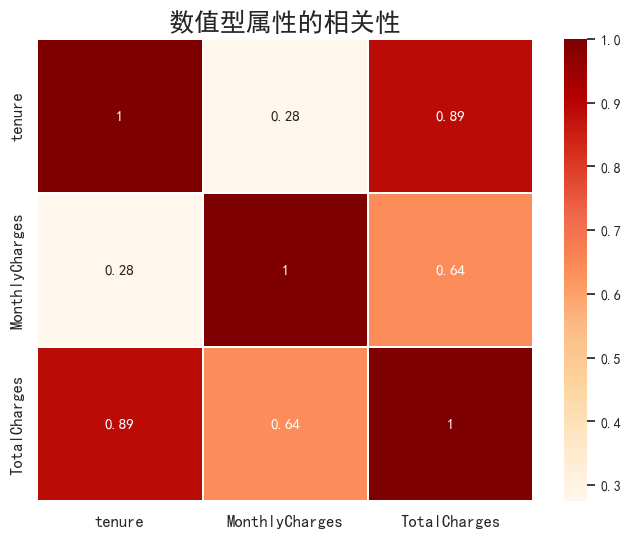

In [10]:
#探索数值型变量相关性
#中文显示问题
import matplotlib
# matplotlib.rc("font",family='SimHei')
rc = {'font.sans-serif': 'SimHei',
      'axes.unicode_minus': False}
sns.set(font_scale=0.9,rc=rc)

plt.figure(figsize=(8, 6))  
sns.heatmap(df[num_cols].corr('spearman'), linewidths=0.1, cmap='OrRd', annot=True)
plt.title('数值型属性的相关性', fontdict={'fontsize': 'xx-large', 'fontweight':'heavy'}) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show() 

In [11]:
# 对于二分类变量，编码为0和1;
# 对于多分类变量，进行one_hot编码；
# 对于数值型变量，部分模型如KNN、神经网络、Logistic需要进行标准化处理。
# 建模数据
from sklearn.preprocessing import LabelEncoder
df_model = df
Id_col = ['customerID']
target_col = ['Churn']
# 分类型
cat_cols = df_model.nunique()[df_model.nunique() < 10].index.tolist()
# 二分类属性
binary_cols = df_model.nunique()[df_model.nunique() == 2].index.tolist()
# 多分类属性
multi_cols = [i for i in cat_cols if i not in binary_cols]
# 数值型
num_cols = [i for i in df_model.columns if i not in cat_cols + Id_col]
# 二分类-标签编码
le = LabelEncoder()
for i in binary_cols:
    df_model[i] = le.fit_transform(df_model[i])
# 多分类-哑变量转换
df_model = pd.get_dummies(data=df_model, columns=multi_cols)
df_model.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_Tenure_1,tenure_group_Tenure_2,tenure_group_Tenure_3,tenure_group_Tenure_4,tenure_group_Tenure_5,tenure_group_Tenure_over_5
0,7590-VHVEG,0,0,1,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,3668-QPYBK,1,0,0,0,2,1,0,1,1,...,0,0,0,1,1,0,0,0,0,0
3,7795-CFOCW,1,0,0,0,45,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,9237-HQITU,0,0,0,0,2,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0


C:\Users\wkb\AppData\Local\Temp\ipykernel_25368\4001283180.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



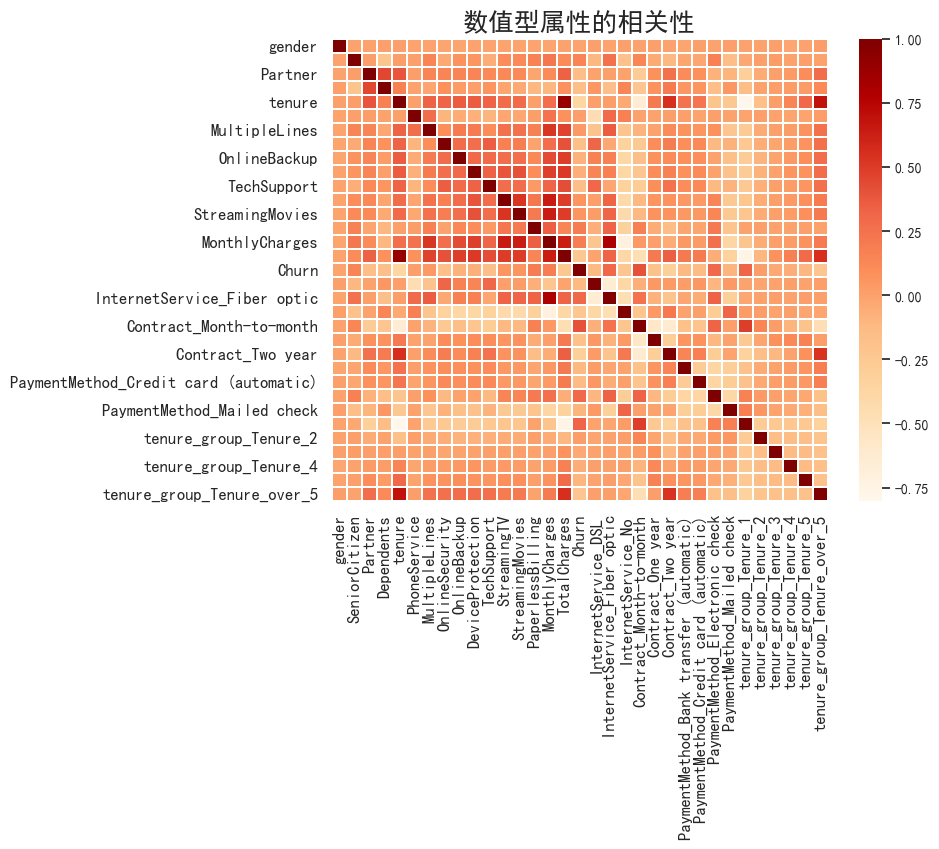

In [12]:
plt.figure(figsize=(8, 6))  
sns.heatmap(df_model.corr('spearman'), linewidths=0.1, cmap='OrRd', annot=False, )
plt.title('数值型属性的相关性', fontdict={'fontsize': 'xx-large', 'fontweight':'heavy'}) 
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show() 

In [13]:
# 使用统计检定方式进行特征筛选。
#from sklearn import feature_selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X = df_model.copy().drop(['customerID','Churn'], axis=1)
y = df_model[target_col]
fs = SelectKBest(score_func=f_classif, k=20)
X_train_fs = fs.fit_transform(X, y.to_numpy().ravel())
X_train_fs.shape

(7032, 20)

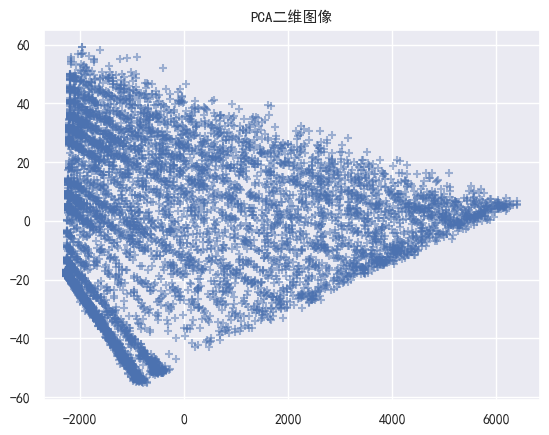

[9.99860343e-01 1.22159544e-04] 0.9999825022272776
[5.13904777e+06 6.27871418e+02]


In [14]:
from sklearn.decomposition import PCA

pca2d = PCA(n_components=2)
pca2d.fit(X)
x_pca = pca2d.transform(X)
plt.title('PCA二维图像')
plt.scatter(x_pca[:, 0], x_pca[:, 1], marker='+', alpha=0.5)
plt.show()

print(pca2d.explained_variance_ratio_, pca2d.explained_variance_ratio_.sum())
print(pca2d.explained_variance_)

In [15]:
def SelectName(feature_data, model):
    # 选择出前20高分的列索引
    scores = model.scores_
    indices = np.argsort(scores)[::-1]
    return list(feature_data.columns.values[indices[0:model.k]])
# 输出选择变量名称
# SelectName(X,fs)
fea_name = [i for i in X.columns if i in SelectName(X,fs)]
X_train = pd.DataFrame(X_train_fs,columns = fea_name)
X_train.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity',
       'TechSupport', 'PaperlessBilling', 'MonthlyCharges', 'TotalCharges',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'tenure_group_Tenure_1',
       'tenure_group_Tenure_over_5'],
      dtype='object')

In [16]:
# 模型建立和评估
# 首先使用分层抽样的方式将数据划分训练集和测试集。
# 重新划分
# 分层抽样
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#修正索引
for i in[X_train, X_test, y_train, y_test]:

    i.index = range(i.shape[0])

# 保存标准化训练和测试数据
st= StandardScaler()
num_scaled_train= pd.DataFrame(st.fit_transform(X_train[num_cols]), columns=num_cols)
num_scaled_test= pd.DataFrame(st.transform(X_test[num_cols]), columns=num_cols)
X_train_scaled= pd.concat([X_train.drop(num_cols, axis= 1), num_scaled_train], axis= 1)
X_test_scaled= pd.concat([X_test.drop(num_cols, axis= 1), num_scaled_test], axis= 1)

(5625, 20) (1407, 20) (5625, 1) (1407, 1)


In [17]:
# 建模
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier

# 模型评估
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score

def model_report(model, X_train, X_test, y_train, y_test, name):
    y_train = y_train.to_numpy().ravel()
    model.fit(X_train, y_train)
    y_pred  = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:,1]
    
    # 评估指标
    accuracy = accuracy_score(y_test, y_pred)
    recallscore = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
#     roc_auc = roc_auc_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)
    f1score = f1_score(y_test, y_pred) 
    kappa_metric = cohen_kappa_score(y_test, y_pred)
    
    # 保存数据
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df


# 实例模型
logit = LogisticRegression() 

knn = KNeighborsClassifier(n_neighbors=5) 

svc_lin  = SVC(kernel='linear', random_state=0, probability=True) 

svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True) 

mlp_model = MLPClassifier(hidden_layer_sizes=(8,), alpha=0.05, max_iter=50000, 
                          activation='relu', random_state=0)

gnb = GaussianNB()

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)  

rfc = RandomForestClassifier(n_estimators=100, random_state=0) 

lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0) 

# xgc = XGBClassifier(n_estimators=100, eta=0.02, max_depth=15, random_state=0, learning_rate=0.001)

# 调用函数
model1 = model_report(logit, X_train_scaled, X_test_scaled, y_train, y_test,
                      "Logistic Regression")
model2 = model_report(knn, X_train_scaled, X_test_scaled, y_train, y_test,
                      "KNN Classifier")
model3 = model_report(svc_lin, X_train_scaled, X_test_scaled, y_train, y_test,
                      "SVM Classifier Linear")
model4 = model_report(svc_rbf, X_train_scaled, X_test_scaled, y_train, y_test,
                      "SVM Classifier RBF")
model5 = model_report(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test,
                      "MLP Classifier")
model6 = model_report(gnb, X_train, X_test, y_train, y_test,
                      "Naive Bayes")
model7 = model_report(decision_tree, X_train, X_test, y_train, y_test,
                      "Decision Tree")
model8 = model_report(rfc, X_train, X_test, y_train, y_test,
                      "Random Forest Classifier")
model9 = model_report(lgbm_c, X_train, X_test, y_train, y_test,
                      "LGBM Classifier") 
# model10 = model_report(xgc, X_train, X_test, y_train, y_test,
#                       "XGBoost Classifier")

# 拼接表
model_performances = pd.concat([model1, model2, model3,
                                model4, model5, model6,
                                model7, model8, model9# , model10
                                ], axis=0).reset_index()

model_performances = model_performances.drop(columns="index",axis =1)

table  = ff.create_table(np.round(model_performances, 4))

py.offline.iplot(table) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


In [18]:
# 我们也可以对模型进行进一步优化，比如对决策树参数进行调优。
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
parameters = { 'splitter': ( 'best', 'random'),
              'criterion': ( "gini", "entropy"),
              "max_depth": [* range( 3, 20)],
}

clf = DecisionTreeClassifier(random_state= 25)

GS = GridSearchCV(clf, parameters, scoring= 'f1', cv= 10)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)
clf = GS.best_estimator_
test_pred = clf.predict(X_test)
print('测试集：\n', classification_report(y_test, test_pred))

{'criterion': 'entropy', 'max_depth': 5, 'splitter': 'best'}
0.6014522720158608
测试集：
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.62      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.71      1407
weighted avg       0.78      0.79      0.78      1407



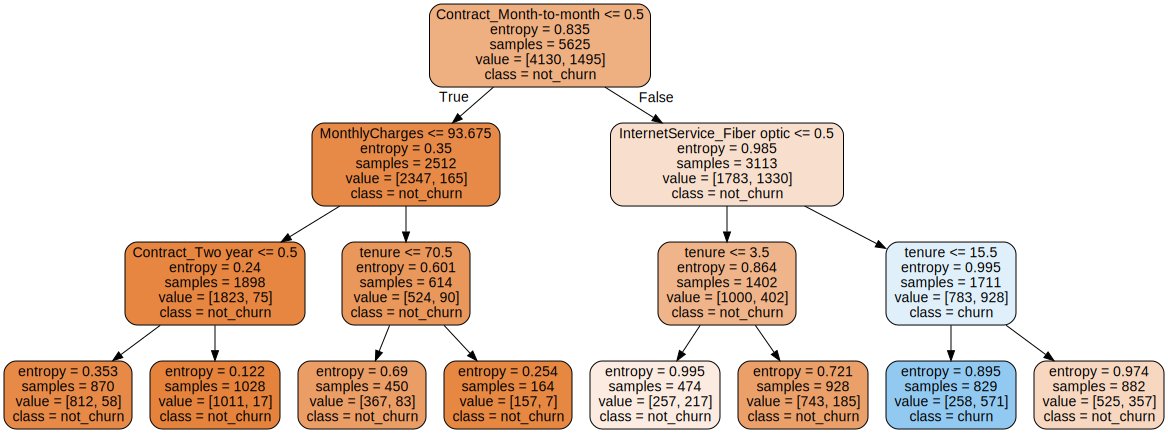

In [19]:
#将这棵树画出来
import graphviz
# from pydotplus.graphviz import graph_from_dot_data
# from sklearn.tree import export_graphviz

part_DT = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
part_DT.fit(X_train, y_train)

dot_data = tree.export_graphviz(decision_tree=part_DT, max_depth=3,
                                 out_file=None, 
#                                  feature_names=X_train.columns,
                                 feature_names = X_train.columns,
                                 class_names=['not_churn', 'churn'], 
                                 filled=True,
                                 rounded=True
                                )
graph = graphviz.Source(dot_data)
graph
# graph = graph_from_dot_data(dot_data) # Create graph from dot data

# graph.write_png('./决策树.png') # Write graph to PNG image

In [20]:
# 输出决策树属性重要性排序
import plotly.figure_factory as ff

import plotly as py

imp = pd.DataFrame(zip(X_train.columns, clf.feature_importances_))

imp.columns = ['feature', 'importances']

imp = imp.sort_values('importances', ascending=False)

imp = imp[imp['importances'] != 0]

table = ff.create_table(np.round(imp, 4))

py.offline.iplot(table)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


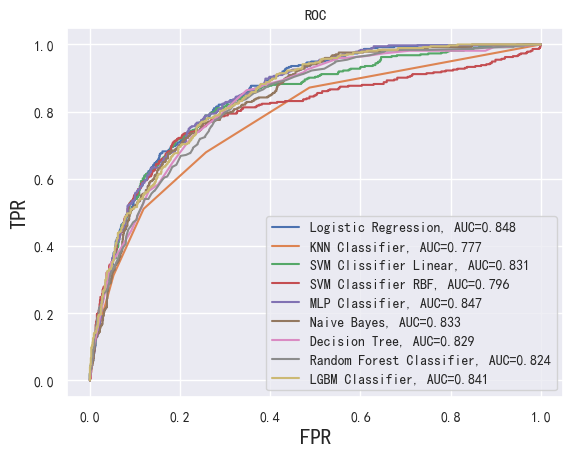

In [21]:
#绘制ROC曲线
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

def draw_roc(title='ROC'):
    fprs = []
    tprs = []
    aucs=[]

    def roc_img(model, X_train, X_test, y_train, y_test, name):
        y_train = y_train.to_numpy().ravel()
        model.fit(X_train, y_train)
        y_score = model.predict_proba(X_test)[:,1]

        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr,tpr)

        # print(roc_auc)
        
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(roc_auc)

    models = [logit, knn, svc_lin, svc_rbf, mlp_model, gnb, decision_tree, rfc, lgbm_c]
    names = [ "Logistic Regression",  "KNN Classifier", "SVM Clissifier Linear", 
            "SVM Classifier RBF","MLP Classifier", "Naive Bayes", "Decision Tree",
            "Random Forest Classifier", "LGBM Classifier"# , "XGBoost Classifier"
            ]

    for i in range(len(names)):
        if i<5:
            roc_img(models[i], X_train_scaled, X_test_scaled, y_train, y_test, names[i])
        else:
            roc_img(models[i], X_train, X_test, y_train, y_test, names[i])
        plt.plot(fprs[i],tprs[i], lw=1.5, label="%s, AUC=%.3f"%(names[i],aucs[i]))
        
    plt.xlabel("FPR",fontsize=15)
    plt.ylabel("TPR",fontsize=15)

    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()
    
draw_roc()

## 十折交叉验证

In [22]:
from sklearn.model_selection import StratifiedKFold
from tqdm import *

# 初始化模型
logit = LogisticRegression() 

knn = KNeighborsClassifier(n_neighbors=5) 

svc_lin  = SVC(kernel='linear', random_state=0, probability=True) 

svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True) 

mlp_model = MLPClassifier(hidden_layer_sizes=(8,), alpha=0.05, max_iter=50000, 
                          activation='relu', random_state=0)

gnb = GaussianNB()

decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)  

rfc = RandomForestClassifier(n_estimators=100, random_state=0) 

lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0) 

# 进行十折交叉验证
def train_10fold(model, X, y, name):
    # 评估指标
    accuracy = []
    recallscore = []
    precision = []
    # roc_auc = []
    roc_auc = []
    f1score = []
    kappa_metric = []
    
    # 初始化十折交叉验证对象
    kf = StratifiedKFold(n_splits=10, shuffle=True)
    with tqdm(10) as pbar:
        for train_index, val_index in kf.split(X, y):
            # 划分数据
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]
            y_train = y_train.to_numpy().ravel()
            
            # 训练模型
            model.fit(X_train, y_train)
            y_pred  = model.predict(X_val)
            y_score = model.predict_proba(X_val)[:,1]
            
            # 记录评估指标
            accuracy.append(accuracy_score(y_val, y_pred))
            recallscore.append(recall_score(y_val, y_pred))
            precision.append(precision_score(y_val, y_pred))
            # roc_auc = roc_auc_score(y_test, y_pred)
            roc_auc.append(roc_auc_score(y_val, y_score))
            f1score.append(f1_score(y_val, y_pred) )
            kappa_metric.append(cohen_kappa_score(y_val, y_pred))
            pbar.update(1)
            pbar.set_description(name)
    
    # 保存数据
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [np.mean(accuracy)],
                       "Recall_score"    : [np.mean(recallscore)],
                       "Precision"       : [np.mean(precision)],
                       "f1_score"        : [np.mean(f1score)],
                       "Area_under_curve": [np.mean(roc_auc)],
                       "Kappa_metric"    : [np.mean(kappa_metric)],
                      })
    return df

        
# 标准化
st= StandardScaler()
num_scaled= pd.DataFrame(st.fit_transform(X[num_cols]), columns=num_cols)
X_scaled= pd.concat([X.drop(num_cols, axis= 1), num_scaled], axis= 1)

# 使用标准化数据
model1 = train_10fold(logit, X_scaled, y, "Logistic Regression")
model2 = train_10fold(knn, X_scaled, y, "KNN Classifier")
model3 = train_10fold(svc_lin, X_scaled, y, "SVM Classifier Linear")
model4 = train_10fold(svc_rbf, X_scaled, y, "SVM Classifier RBF")
model5 = train_10fold(mlp_model, X_scaled, y, "MLP Classifier")

model6 = train_10fold(gnb, X, y, "Naive Bayes")
model7 = train_10fold(decision_tree, X, y, "Decision Tree")
model8 = train_10fold(rfc, X, y, "Random Forest Classifier")
model9 = train_10fold(lgbm_c, X, y, "LGBM Classifier") 

# 可视化
model_performances = pd.concat([model1, model2, model3,
                                model4, model5, model6,
                                model7, model8, model9# , model10
                                ], axis=0).reset_index()

model_performances = model_performances.drop(columns="index",axis =1)

table  = ff.create_table(np.round(model_performances, 4))

py.offline.iplot(table) 

0it [00:00, ?it/s]

c:\Users\wkb\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

Logistic Regression: : 1it [00:00, 11.80it/s]c:\Users\wkb\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#lo

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4646
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000860 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 6328, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265803 -> initscore=-1.016023
[LightGBM] [Info] Start training from score -1.016023
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4646
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Numb

LGBM Classifier: : 5it [00:00, 12.56it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 6329, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265761 -> initscore=-1.016238
[LightGBM] [Info] Start training from score -1.016238
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

LGBM Classifier: : 8it [00:00, 11.84it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 6329, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265761 -> initscore=-1.016238
[LightGBM] [Info] Start training from score -1.016238
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

LGBM Classifier: : 10it [00:00, 12.09it/s]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1682, number of negative: 4647
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 6329, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265761 -> initscore=-1.016238
[LightGBM] [Info] Start training from score -1.016238


## 类别不平衡

### 过采样与负采样

In [23]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# 定义RandomOverSampler和RandomUnderSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# 进行过采样
X_over_sampled, y_over_sampled = ros.fit_resample(X, y)

# 进行欠采样
X_under_sampled, y_under_sampled = rus.fit_resample(X, y)

In [24]:
# 使用欠采样数据集
X_train, X_test, y_train, y_test = train_test_split(X_under_sampled, y_under_sampled, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
for i in[X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])
st= StandardScaler()
num_scaled_train= pd.DataFrame(st.fit_transform(X_train[num_cols]), columns=num_cols)
num_scaled_test= pd.DataFrame(st.transform(X_test[num_cols]), columns=num_cols)
X_train_scaled= pd.concat([X_train.drop(num_cols, axis= 1), num_scaled_train], axis= 1)
X_test_scaled= pd.concat([X_test.drop(num_cols, axis= 1), num_scaled_test], axis= 1)
# 实例模型
logit = LogisticRegression() 
knn = KNeighborsClassifier(n_neighbors=5) 
svc_lin  = SVC(kernel='linear', random_state=0, probability=True) 
svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True) 
mlp_model = MLPClassifier(hidden_layer_sizes=(8,), alpha=0.05, max_iter=50000, activation='relu', random_state=0)
gnb = GaussianNB()
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)  
rfc = RandomForestClassifier(n_estimators=100, random_state=0) 
lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0) 
model1 = model_report(logit, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
model2 = model_report(knn, X_train_scaled, X_test_scaled, y_train, y_test, "KNN Classifier")
model3 = model_report(svc_lin, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier Linear")
model4 = model_report(svc_rbf, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier RBF")
model5 = model_report(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, "MLP Classifier")
model6 = model_report(gnb, X_train, X_test, y_train, y_test, "Naive Bayes")
model7 = model_report(decision_tree, X_train, X_test, y_train, y_test, "Decision Tree")
model8 = model_report(rfc, X_train, X_test, y_train, y_test, "Random Forest Classifier")
model9 = model_report(lgbm_c, X_train, X_test, y_train, y_test, "LGBM Classifier") 
model_performances = pd.concat([model1, model2, model3,
                                model4, model5, model6,
                                model7, model8, model9
                                ], axis=0).reset_index()
model_performances = model_performances.drop(columns="index",axis =1)
table  = ff.create_table(np.round(model_performances, 4))
py.offline.iplot(table) 

(2990, 32) (748, 32) (2990, 1) (748, 1)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1504, number of negative: 1486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 2990, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503010 -> initscore=0.012040
[LightGBM] [Info] Start training from score 0.012040


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1504, number of negative: 1486
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 2990, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503010 -> initscore=0.012040
[LightGBM] [Info] Start training from score 0.012040


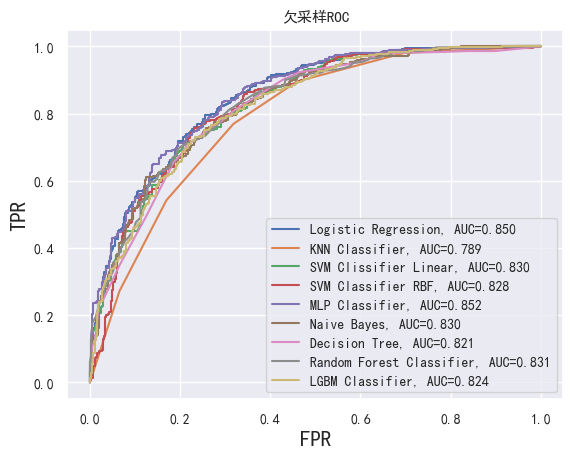

In [25]:
draw_roc('欠采样ROC')

In [26]:
# 使用过采样数据集
X_train, X_test, y_train, y_test = train_test_split(X_over_sampled, y_over_sampled, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
for i in[X_train, X_test, y_train, y_test]:
    i.index = range(i.shape[0])
st= StandardScaler()
num_scaled_train= pd.DataFrame(st.fit_transform(X_train[num_cols]), columns=num_cols)
num_scaled_test= pd.DataFrame(st.transform(X_test[num_cols]), columns=num_cols)
X_train_scaled= pd.concat([X_train.drop(num_cols, axis= 1), num_scaled_train], axis= 1)
X_test_scaled= pd.concat([X_test.drop(num_cols, axis= 1), num_scaled_test], axis= 1)
# 实例模型
logit = LogisticRegression() 
knn = KNeighborsClassifier(n_neighbors=5) 
svc_lin  = SVC(kernel='linear', random_state=0, probability=True) 
svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True) 
mlp_model = MLPClassifier(hidden_layer_sizes=(8,), alpha=0.05, max_iter=50000, activation='relu', random_state=0)
gnb = GaussianNB()
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)  
rfc = RandomForestClassifier(n_estimators=100, random_state=0) 
lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0) 
model1 = model_report(logit, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
model2 = model_report(knn, X_train_scaled, X_test_scaled, y_train, y_test, "KNN Classifier")
model3 = model_report(svc_lin, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier Linear")
model4 = model_report(svc_rbf, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier RBF")
model5 = model_report(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, "MLP Classifier")
model6 = model_report(gnb, X_train, X_test, y_train, y_test, "Naive Bayes")
model7 = model_report(decision_tree, X_train, X_test, y_train, y_test, "Decision Tree")
model8 = model_report(rfc, X_train, X_test, y_train, y_test, "Random Forest Classifier")
model9 = model_report(lgbm_c, X_train, X_test, y_train, y_test, "LGBM Classifier") 
model_performances = pd.concat([model1, model2, model3,
                                model4, model5, model6,
                                model7, model8, model9
                                ], axis=0).reset_index()
model_performances = model_performances.drop(columns="index",axis =1)
table  = ff.create_table(np.round(model_performances, 4))
py.offline.iplot(table) 

(8260, 32) (2066, 32) (8260, 1) (2066, 1)


c:\Users\wkb\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4134, number of negative: 4126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500484 -> initscore=0.001937
[LightGBM] [Info] Start training from score 0.001937


c:\Users\wkb\.conda\envs\pytorch\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4134, number of negative: 4126
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500484 -> initscore=0.001937
[LightGBM] [Info] Start training from score 0.001937


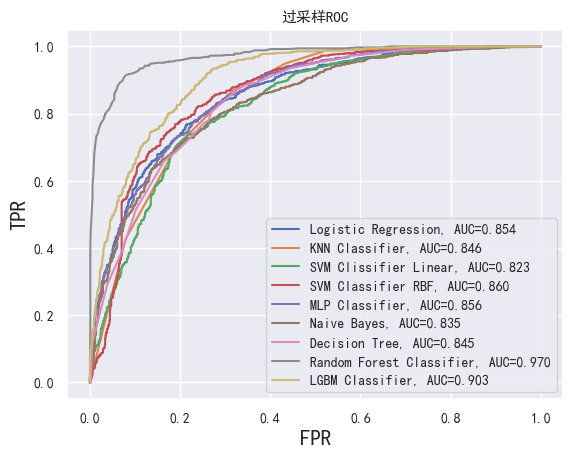

In [27]:
draw_roc('过采样ROC')

### 调整模型训练权重

In [28]:
# 再次划分训练集测试集
fea_name = [i for i in X.columns if i in SelectName(X,fs)]
X_train = pd.DataFrame(X_train_fs,columns = fea_name)

X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=0, stratify=y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#修正索引
for i in[X_train, X_test, y_train, y_test]:

    i.index = range(i.shape[0])

# 保存标准化训练和测试数据
st= StandardScaler()
num_scaled_train= pd.DataFrame(st.fit_transform(X_train[num_cols]), columns=num_cols)
num_scaled_test= pd.DataFrame(st.transform(X_test[num_cols]), columns=num_cols)
X_train_scaled= pd.concat([X_train.drop(num_cols, axis= 1), num_scaled_train], axis= 1)
X_test_scaled= pd.concat([X_test.drop(num_cols, axis= 1), num_scaled_test], axis= 1)

(5625, 20) (1407, 20) (5625, 1) (1407, 1)


In [29]:
# 设置权重
weight={0: 3, 1: 7}

# 选择可以设置权重的模型调整
logit = LogisticRegression(class_weight=weight) 
svc_lin  = SVC(kernel='linear', random_state=0, probability=True, class_weight=weight) 
svc_rbf  = SVC(kernel='rbf', random_state=0, probability=True, class_weight=weight) 
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0, class_weight=weight)  
rfc = RandomForestClassifier(n_estimators=100, random_state=0, class_weight=weight) 
lgbm_c = LGBMClassifier(boosting_type='gbdt', n_estimators=100, random_state=0, class_weight=weight) 
model1 = model_report(logit, X_train_scaled, X_test_scaled, y_train, y_test, "Logistic Regression")
model3 = model_report(svc_lin, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier Linear")
model4 = model_report(svc_rbf, X_train_scaled, X_test_scaled, y_train, y_test, "SVM Classifier RBF")
model7 = model_report(decision_tree, X_train, X_test, y_train, y_test, "Decision Tree")
model8 = model_report(rfc, X_train, X_test, y_train, y_test, "Random Forest Classifier")
model9 = model_report(lgbm_c, X_train, X_test, y_train, y_test, "LGBM Classifier") 
model_performances = pd.concat([model1, model3,
                                model4, 
                                model7, model8, model9
                                ], axis=0).reset_index()
model_performances = model_performances.drop(columns="index",axis =1)
table  = ff.create_table(np.round(model_performances, 4))
py.offline.iplot(table) 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457887 -> initscore=-0.168853
[LightGBM] [Info] Start training from score -0.168853


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.457887 -> initscore=-0.168853
[LightGBM] [Info] Start training from score -0.168853


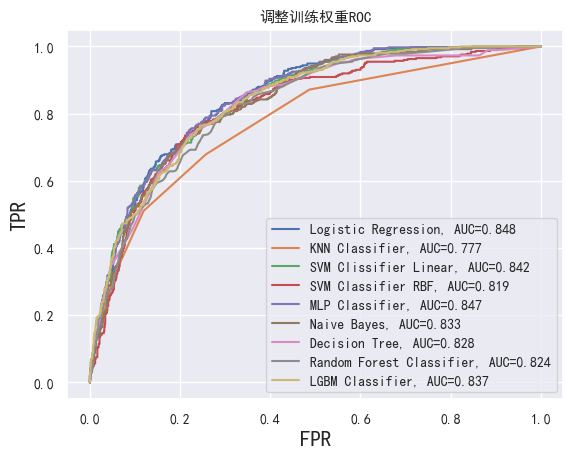

In [30]:
draw_roc('调整训练权重ROC')